<center> 

# Assignment 1 - Evolutionary process discovery
</center>

## Processes and Petri Nets
The financial institute PETRINAS manages loan requests from its customers according to a not well-formalized process model. The process starts when a request is received. Then, the request passes preliminary assessments, aimed at verifying whether the applicant meets the requirements. The request also undergoes frauds detection. As soon as an application is not eligible, the process is terminated. The user receives an offer and can communicate whether he/she intends to accept it. If this is not the case, the process ends. Otherwise, a contract is drawn and finally sent to the customer. The actual sequence of these actions is unknown to the institute.

A sequence of actions can be formalized and investigated using a Petri Net (PN). A PN is a directed bipartite graph characterized by two sets of nodes: the places (used to represent the status of the process) and the transitions (corresponding to the activities described above) connecting the places. Places can only be connected to transitions, and transitions can only be connected to places.

PNs can be effective to represent and study processes. For example, the PN shown in Fig. 1 represents one possible action: receiving the request, a transition which brings from place p1 to place p2.


<center>

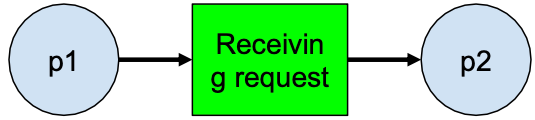

**Fig. 1** - Example of Petri net with two places and one transitions

</center>

Given a set of $𝑀$ places and a set of $𝑁$ transitions, we can represent the PN’s connections using a matrix $𝐴$ of dimension $𝑀 \times 𝑁$.
The $𝑚$-th row in the matrix denotes the 𝑚-th place. The 𝑛-th column represents the 𝑛-th transition. Then, the element $𝑎_{𝑚,𝑛}$ of the matrix encodes the connection between the $𝑚$-th place and the $𝑛$-th transition.

- if $a_{m,n}=-1$ then an arc connects the $m$-th place to the $n$-th transition;
- if $a_{m,n}= 1$ then an arc connects the $n$-th transition to the $m$-th place;

As an example, consider the PN in Fig. 2.

<center>

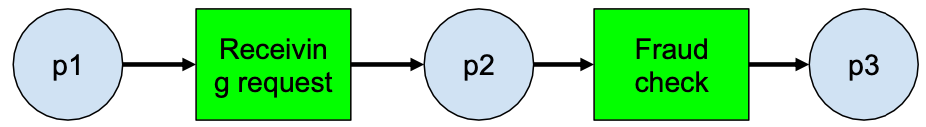

**Fig. 2** - Example of Petri net with three places and two transitions

</center>

The PN in Fig. 2 can be represented by the following $3\times 2$ matrix:

$$\begin{matrix}
  -1&0\\
   1&-1\\
   0&1
\end{matrix}
$$

Given a PN encoded as a matrix, we can perform a simulation of a process by starting from an arbitrary place (we will use p1 as default) and “follow the arcs”. If we keep track of the transitions (i.e., activities) followed during the simulation we get a simulated **trace**. For instance, the PN in Fig. 2 can produce the following trace:

<center>“Receiving request”, “Fraud check”</center>

The company PETRINAS has collected a dataset composed of 100 traces of this kind from their processes (contained in the file ```dataset_a2.txt``` ) and is
now interested in creating and investigating the associated PN. The company knows that there are 10 clear activities + 2 “invisible activities” in their process, which corresponds to an unknown matrix with dimension $12\times 12$ to be discovered. Considering that each element of the matrix can take values {-1, 0, 1} then the number of possible PNs to be tested is $3^{144} \approx 5 × 10^{68}$ which is clearly not feasible by means of an exhaustive search.


## Genetic Algorithms to the rescue
We can explore this huge search space using a **Genetic Algorithm** (GA). The candidate solutions (i.e., the PN matrices) can be encoded as **linearized lists of integer numbers**. For instance, the PN in Fig. 2 can be encoded as: [-1, 0, 1, -1, 0, 1].

A very simple fitness function for a candidate solution can be based on the **simulation** of the experimental traces. Specifically, given a candidate PN whose fitness value must be assessed, we can iterate on each trace of the dataset and see whether the PN can actually simulate that trace correctly. For each correct step taken the PN in a trace, we accumulate +1 in a counter. As soon as the simulation is blocked (because we cannot take the next expected transition from the place that we reached in the PN), the simulation of that trace terminates and we start over with the following trace. When no more traces can be simulated, the counter is returned as the fitness value for that PN.

The pseudocode of the aforementioned fitness function is shown below:

```
def fitness(A):
    counter = 0
    for trace in dataset:
        current_place = p1
        for activity in trace:
            if A[current_place][activity] == -1:
                counter += 1
                current_place = get_new_place(A, activity)
            else: 
                break
    return counter
```

If we try to optimize this fitness function, we find out that the GA tend to converge to a complex PN with several arcs. In order to mitigate this phenomenon, we can introduce a penalty factor in the formula. For instance, we can penalize the number arcs in the PN, in order to promote smaller solutions (see, e.g., De Medeiros et al., “Using Genetic Algorithms to Mine Process Models”). To do so, we can change the last line of the function as follows:

```
return w*counter - (1-w)*count_nonzero(A)
```

where ```count_nonzero()``` is a function that returns the total number of elements in A that are not equal to 0. By using this approach, PNs with a lot of arcs get penalized. In the equation, the contribution of the correct traces and the regularization terms is balanced with a real parameter w in [0,1]. The greater the value, the higher the contribution of the traces to the final fitness value. You can find this fitness function and the simulation code already implemented in the ```support.py``` file on Canvas (in this assignment, we set w=0.9).


### Dataset 

In [1]:
# Importing libraries
import numpy as np
from matplotlib.pyplot import * 
import operator
import random
import pandas as pd


# Calling the Data-set
transitions = [ "Receiving Request", "First Assessment", "Fraud Check",  "Invisible 2", "Invisible 1",
"Accept", "Decline", "Create Offer", "Contact Customer", 
"Offer Refused", "Draw Contract", "Send Contract", ]
names_to_transition = dict(zip(transitions, range(len(transitions))))

PLACES = 12
TRANSITIONS = 12

# helper conversion list to numpy array
def list_to_array(sol): return np.array(sol).reshape((PLACES, TRANSITIONS))

# loads and prepares the dataset for fitness evaluations
def load_dataset(path):
	res = []
	with open(path) as fi:
		for line in fi:
			res.append(line.strip().split(", "))
	return res


dataset = load_dataset("dataset_a1.txt")


# # Converting the dataset into numerics from names_to_transition
# dataset_numeric = []
# for i in range(0,100):
# 	# List comprehension conversion and appending it to the empty dataset_numeric list
# 	dataset_numeric.append([names_to_transition[dataset[i][j]] for j in range(0, len(dataset[i]))])


In [2]:
# fitness evaluation
def fitness(sol, w=0.9):
	sol = list_to_array(sol)
	result = 0
	for trace in dataset:
		fit, _ = evaluate_sequence(sol, trace) 
		result += fit
	return w*result-(1-w)*np.count_nonzero(sol),

# evaluates a sequence of actions from the dataset, 
# using the Petri net encoded in the matrix
def evaluate_sequence(matrix, sequence): 
	code_sequence = [names_to_transition[x] for x in sequence]
	pos = 0 # start from place 0
	total = 0 
	properly = True
	places, n_trans = matrix.shape
	for code in code_sequence:
		if matrix[pos][code]==-1:
			total +=1
			for i in range(places):
				if matrix[i][code]==1:
					pos=i
					break
		else:
			properly = False
			continue
	return total, properly

# The Petri net grapher
def matrix_to_graphviz(matrix, output_file="output.pdf"):
	from pm4py.objects.petri_net.obj import PetriNet, Marking
	from pm4py.visualization.petri_net import visualizer as pn_visualizer
	from pm4py.objects.petri_net.utils.petri_utils import add_arc_from_to

	matrix = list_to_array(matrix)

	net = PetriNet("PETRINAS")
	places, n_trans = matrix.shape

	for d in range(places):
		np = PetriNet.Place("p%d" % (d + 1))
		net.places.add(np)

	for d in range(n_trans):
		nt = PetriNet.Transition(transitions[d], transitions[d])
		net.transitions.add(nt)

	for nt, transition in enumerate(matrix.T):
		for np, place in enumerate(transition):

			# ingoing
			if place == 1:

				from_node1 = to_node1 = None

				for from_tran in list(net.transitions):
					if str(from_tran).split(", ")[0][1:] != transitions[nt]: continue
					from_node1 = from_tran

				for to_place in net.places:
					if str(to_place) != 'p%d' % (np + 1): continue
					to_node1 = to_place

				add_arc_from_to(from_node1, to_node1, net)

			elif place == -1:

				from_node2 = to_node2 = None

				for from_place in net.places:
					if str(from_place) != 'p%d' % (np + 1): continue
					from_node2 = from_place

				for to_tran in list(net.transitions):
					if str(to_tran).split(", ")[0][1:] != transitions[nt]: continue
					to_node2 = to_tran

				add_arc_from_to(from_node2, to_node2, net)

	parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "pdf"}
	gviz = pn_visualizer.apply(net, parameters=parameters)
	pn_visualizer.save(gviz, output_file)

### Question 1: Genetic Algorithm in DEAP 

use [‘cxTwoPoint’, ‘mutFlipBit’, ‘selTournament’] as the [Crossover, Mutation, Selection] operators, record the default parameter of your initial GA and plot the best fitness at each iteration ;

gen	nevals	avg   	min 	max  
0  	50    	155.12	-9.4	360.6
1  	49    	219.688	28.4	381.2
2  	42    	260.874	99.3	419.6
3  	48    	303.958	100.5	419.9
4  	45    	344.026	99.5 	438.3
5  	40    	377.118	86.2 	438.3
6  	42    	374.06 	182  	438.2
7  	44    	390.324	205.4	438.3
8  	44    	403.204	342.9	438.4
9  	42    	400.534	248.3	438.6
10 	46    	409.972	267.7	438.9
11 	47    	404.334	194.4	439.1
12 	50    	410.634	225.2	439.2
13 	48    	419.938	81.5 	439.3
14 	46    	428.738	226.6	439.4
15 	47    	433.74 	264.1	439.4
16 	42    	437.366	343.8	439.5
17 	44    	424.14 	82.5 	439.7
18 	50    	416.584	179.5	439.8
19 	50    	431.248	197.9	439.8
20 	47    	432.376	248.8	440  
21 	50    	434.958	354.2	439.9
22 	43    	432.184	248.4	440  
23 	44    	433.786	249  	440.1
24 	44    	435.396	249.2	440.1
25 	44    	430.756	283.3	440.4
26 	48    	429.114	139.1	440.5
27 	46    	435.584	284.2	440.6
28 	49    	433.202	308.7	440.7
29 	50    	426.53 	203.7	440.8
30 	41    	423.274	142.8	440.8
31 	48    	423

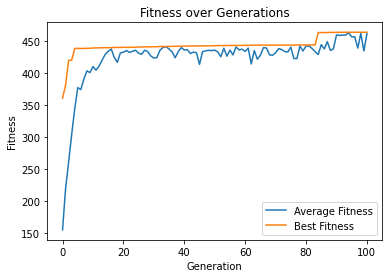

In [3]:
import random
import numpy as np
from deap import base, creator, tools, algorithms

# set up the GA parameters
POPULATION_SIZE = 50
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutation
MAX_GENERATIONS = 100
HALL_OF_FAME_SIZE = 10

# set the random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Define the fitness function and the creator for individuals and population
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Initialize the DEAP toolbox
toolbox = base.Toolbox()

# Define the operators
toolbox.register("attributes", random.randint, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
                 toolbox.attributes, n=PLACES*TRANSITIONS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

# Initialize the hall of fame
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# Run the algorithm
pop = toolbox.population(n=POPULATION_SIZE)
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                   ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

# Get the best individual
best_individual = hof[0]

# Plot the best fitness at each generation
import matplotlib.pyplot as plt
gen, min_fit, avg_fit, max_fit = logbook.select("gen", "min", "avg", "max")
# plt.plot(gen, min_fit, label="Best Fitness")
plt.plot(gen, avg_fit, label="Average Fitness")
plt.plot(gen, max_fit, label="Best Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.show()



### Question 2
**Compare the performance of possible variants of your GA**, e.g., using different crossover, mutation, and selection operators. Test the variants in the table
below, and investigate both the impact to the **optimization performances** and the overall running time, keep the best choice according to ABF for the later questions.
You can refer to the operators described in DEAP documentation: [Operators](https://deap.readthedocs.io/en/master/api/tools.html#operators-1)

| Crossover | Mutation | Selection | ABF | Time (s) |
| --------- | ----------- | ----------- | ----------- | ----------- |
| cxTwoPoint | mutFlipBit | selTournament | --- | 4.582 |
| cxTwoPoint | mutFlipBit | selRoulette | --- | 2.879 |
| cxTwoPoint | mutShuffleIndexes | selTournament | --- | 4.500 |
| cxTwoPoint | mutShuffleIndexes | selRoulette | --- | 3.205 |
| cxOrdered | mutFlipBit | selTournament | --- | 3.976 |
| cxOrdered | mutFlipBit | selRoulette | --- | 3.027 |
| cxOrdered | mutShuffleIndexes | selTournament | --- | 3.249 |
| cxOrdered | mutShuffleIndexes | selRoulette | --- | 3.175 |

In [4]:
# Listing the Hyper-parameters for the GA
LIST_HYPPARAM = [
[toolbox.register("mate", tools.cxTwoPoint), toolbox.register("mutate", tools.mutFlipBit, indpb=0.05), toolbox.register("select", tools.selTournament, tournsize=3)],
[toolbox.register("mate", tools.cxTwoPoint), toolbox.register("mutate", tools.mutFlipBit, indpb=0.05), toolbox.register("select", tools.selRoulette)],
[toolbox.register("mate", tools.cxTwoPoint), toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05),
 toolbox.register("select", tools.selTournament, tournsize=3)],
[toolbox.register("mate", tools.cxTwoPoint), toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05), toolbox.register("select", tools.selRoulette)],
[toolbox.register("mate", tools.cxOrdered), toolbox.register("mutate", tools.mutFlipBit, indpb=0.05), toolbox.register("select", tools.selTournament, tournsize=3)],
[toolbox.register("mate", tools.cxOrdered), toolbox.register("mutate", tools.mutFlipBit, indpb=0.05), toolbox.register("select", tools.selRoulette)],
[toolbox.register("mate", tools.cxOrdered), toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05), 
 toolbox.register("select", tools.selTournament, tournsize=3)],
[toolbox.register("mate", tools.cxOrdered), toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05), toolbox.register("select", tools.selRoulette)]
]

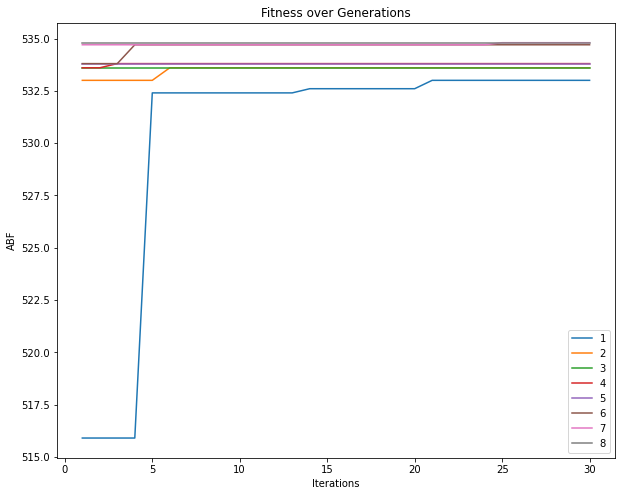

Time Elapsed (seconds):  [58.794, 60.92, 60.431, 62.206, 61.765, 63.727, 63.59, 77.794]
ABF =  [530.447, 533.5, 533.6, 533.787, 533.8, 534.61, 534.72, 534.8]


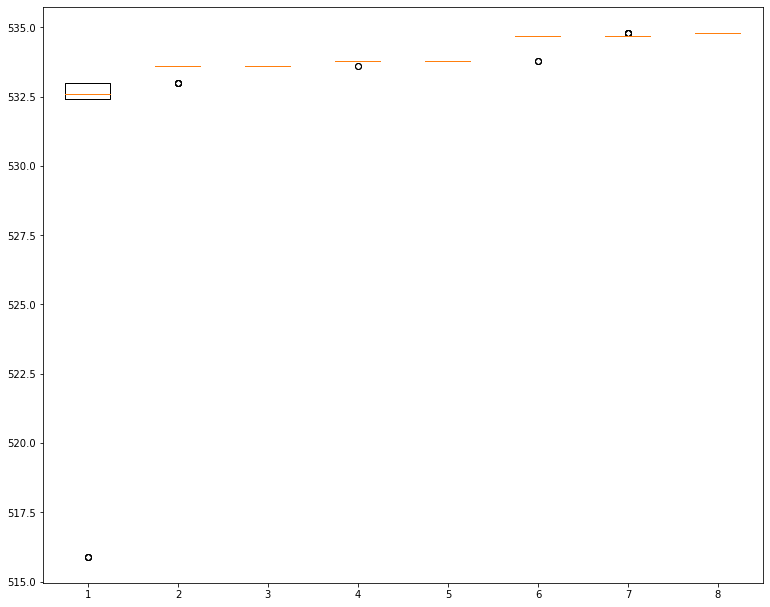

In [5]:
import time

# set up the GA parameters
POPULATION_SIZE = 50
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutation
MAX_GENERATIONS = 100
HALL_OF_FAME_SIZE = 10


# Initialize the hall of fame
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

TIME_LIST = []
BEST_FITNESS = np.zeros((30, 8), dtype=float)
iterList = np.linspace(1,30,30)

# Run the algorithm and plot the best fitness for each iterations
fig = plt.figure(figsize =(10, 8))
for i in range(0, len(LIST_HYPPARAM)):

    LIST_HYPPARAM[i][0]
    LIST_HYPPARAM[i][1]
    LIST_HYPPARAM[i][2]

    start_time = time.time()
    for j in range (0, 30):
        pop = toolbox.population(n=POPULATION_SIZE)
        pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                           ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=False)
        best_individual = hof[0]
        BEST_FITNESS[j][i] = best_individual.fitness.values[0]
    end_time = time.time()
    TIME_LIST.append(end_time - start_time)
    plt.plot(iterList, BEST_FITNESS[:,i], label=f"{i+1}")

plt.title("Fitness over Generations")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("ABF")
plt.show()
## Get the best individual
# best_individual = hof[0]

print("Time Elapsed (seconds): ", [round(elem, 3) for elem in TIME_LIST])
print("ABF = ", [round(elem, 3) for elem in np.mean(BEST_FITNESS, axis=0)])

fig = plt.figure(figsize =(10, 8))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(BEST_FITNESS)
# show plot
plt.show()

### Question 3

Based on our observation, it is optimal to take the GA with '[cxTwoPoint', 'mutFlipBit', 'selRoulette'] as the [Crossover, Mutation, Selection] as it has reasonably computational time and the highest ABF. For this assignment, we will use this *hyperparameter*.

P_CROSSOVER =  0.2 P_MUTATION =  0.2 Best Fitness =  479.12666666666667
P_CROSSOVER =  0.2 P_MUTATION =  0.4 Best Fitness =  495.28999999999996
P_CROSSOVER =  0.2 P_MUTATION =  0.6 Best Fitness =  497.8999999999999
P_CROSSOVER =  0.2 P_MUTATION =  0.8 Best Fitness =  497.8999999999999
P_CROSSOVER =  0.4 P_MUTATION =  0.2 Best Fitness =  507.73999999999984
P_CROSSOVER =  0.4 P_MUTATION =  0.4 Best Fitness =  515.6999999999998
P_CROSSOVER =  0.4 P_MUTATION =  0.6 Best Fitness =  535.2999999999998
P_CROSSOVER =  0.4 P_MUTATION =  0.8 Best Fitness =  535.2999999999998
P_CROSSOVER =  0.6 P_MUTATION =  0.2 Best Fitness =  535.2999999999998
P_CROSSOVER =  0.6 P_MUTATION =  0.4 Best Fitness =  535.2999999999998
P_CROSSOVER =  0.6 P_MUTATION =  0.6 Best Fitness =  535.2999999999998
P_CROSSOVER =  0.6 P_MUTATION =  0.8 Best Fitness =  535.2999999999998
P_CROSSOVER =  0.8 P_MUTATION =  0.2 Best Fitness =  535.2999999999998
P_CROSSOVER =  0.8 P_MUTATION =  0.4 Best Fitness =  535.2999999999998
P_C

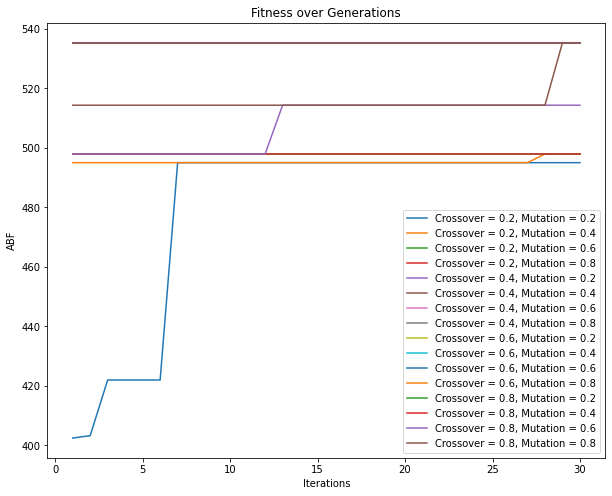

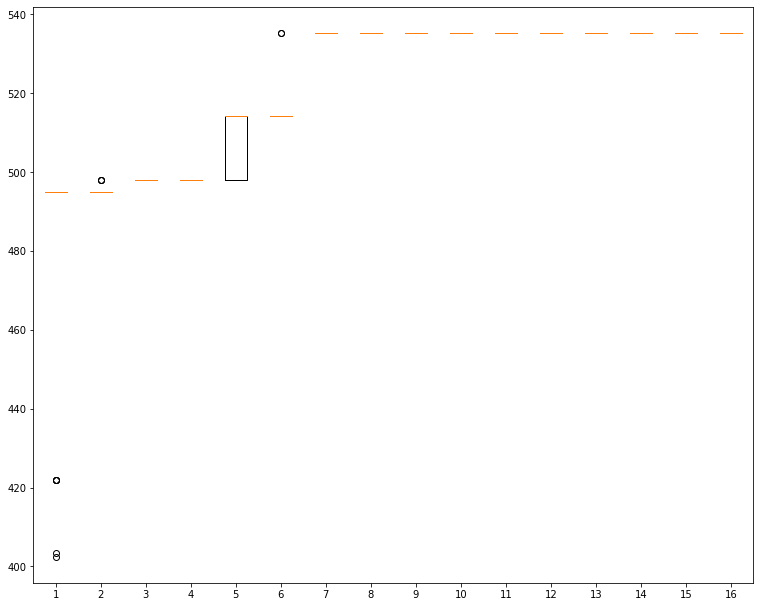

In [10]:
# set up the GA parameters
POPULATION_SIZE = 50
MAX_GENERATIONS = 100
HALL_OF_FAME_SIZE = 10

# List of the hyper-parameters
LIST_P_CROSSOVER = [0.2, 0.4, 0.6, 0.8]
LIST_P_MUTATION = [0.2, 0.4, 0.6, 0.8]

HYPPARAMS = [LIST_P_CROSSOVER, LIST_P_MUTATION]
HYPPARAMS = [[item1, item2] for item1 in LIST_P_CROSSOVER for item2 in LIST_P_MUTATION]


# set the random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Initialize the DEAP toolbox
toolbox3 = base.Toolbox()

# Define the operators
toolbox3.register("attributes", random.randint, -1, 1)
toolbox3.register("individual", tools.initRepeat, creator.Individual, 
                 toolbox3.attributes, n=PLACES*TRANSITIONS)
toolbox3.register("population", tools.initRepeat, list, toolbox.individual)
toolbox3.register("evaluate", fitness)
toolbox3.register("mate", tools.cxTwoPoint)
toolbox3.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox3.register("select", tools.selRoulette)


# Initialize the hall of fame
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
BEST_FITNESS_3 = np.zeros((30, 16), dtype=float)

# Run the algorithm and plotting each instance of the ABF
fig = plt.figure(figsize =(10, 8))
for i in range(len(HYPPARAMS)):
    P_CROSSOVER = HYPPARAMS[i][0]
    P_MUTATION = HYPPARAMS[i][1]
    for j in range (0, 30):
        pop = toolbox3.population(n=POPULATION_SIZE)
        pop, _ = algorithms.eaSimple(pop, toolbox3, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                           ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=False)
        best_individual = hof[0]
        BEST_FITNESS_3[j][i] = best_individual.fitness.values[0] # Temporary best fitness

    # Plotting the ABF for each runs
    plt.plot(np.linspace(1,30,30), BEST_FITNESS_3[:,i], label=f"Crossover = {P_CROSSOVER}, Mutation = {P_MUTATION}")

    print("P_CROSSOVER = ", P_CROSSOVER, "P_MUTATION = ", P_MUTATION, "Best Fitness = ",  np.mean(BEST_FITNESS_3[:,i]))

plt.title("Fitness over Generations")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("ABF")
plt.show()



# Plotting the boxplot for the ABF
fig = plt.figure(figsize =(10, 8))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(BEST_FITNESS_3)
# show plot
plt.show()